##Importing Libraries and Dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Flowers/Fertility'
data_dir = pathlib.Path(data_dir).with_suffix('')

##Image Visualization

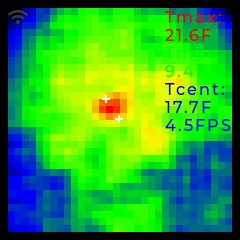

In [ ]:
fertile = list(data_dir.glob('Fertile/*'))
PIL.Image.open(str(fertile[0]))

##Define Some Parameters

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

##Train:Val Split (80:20)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 48 files belonging to 2 classes.
Using 39 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 48 files belonging to 2 classes.
Using 9 files for validation.


## Visualize Some Data

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Fertile', 'Infertile']


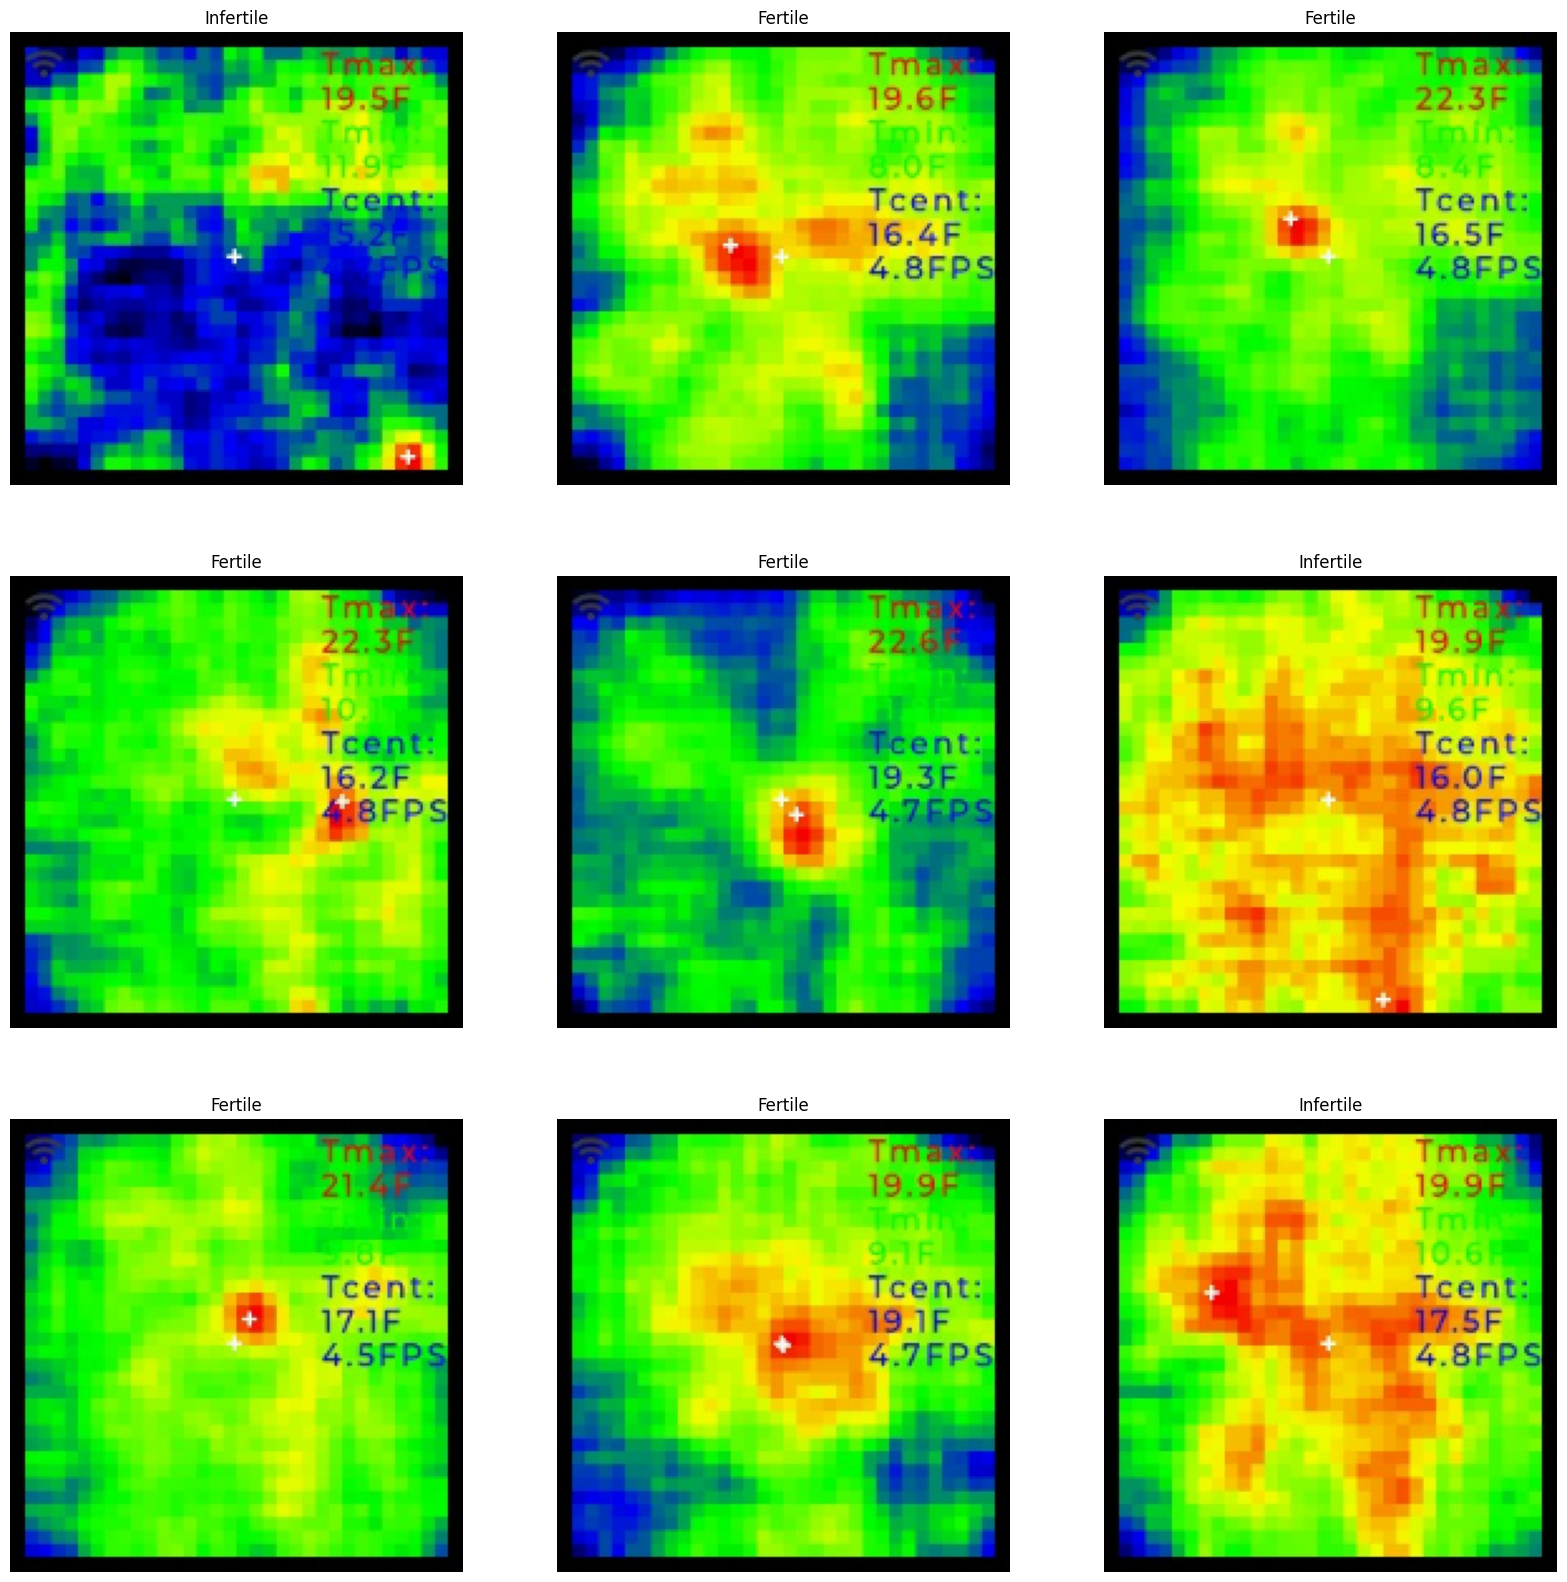

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Image Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

##Visualize Augmented Data

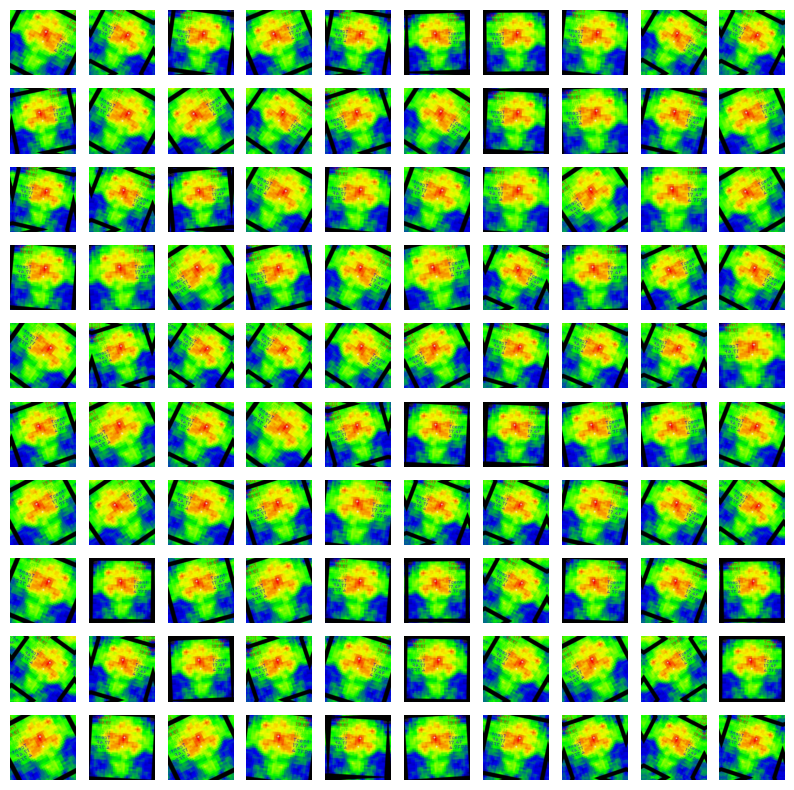

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(100):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##Configure Dataset Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize Data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

## Tensorflow Keras Sequential Model Architecture

In [ ]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and Train

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
#fertility classification
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

## Visualize Training Results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Save Model

In [ ]:
model.save('fertility_detection.keras')

## Predict on Test Data

###Load Model in

In [ ]:
model = tf.keras.models.load_model('fertility_detection.keras')
model.summary()

##Test All

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
import os

detection = "/content/drive/MyDrive/Flowers/Test/Fertility/"
detectionList = os.listdir(detection)
for condition in detectionList:
  print(f"True Class: {condition}")
  print("---------")
  conditionList = os.listdir(detection+condition)
  for item in conditionList:
    img = tf.keras.utils.load_img(detection+condition+"/"+item, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

##Individual Case Testing

In [ ]:
from google.colab import drive
from PIL import Image
from IPython.display import display, Image

drive.mount("/content/drive/")
fertile = "/content/drive/MyDrive/Flowers/Fertility/Fertile/21.jpeg"
infertile = "/content/drive/MyDrive/Flowers/Fertility/Infertile/19.jpeg"
model = tf.keras.models.load_model('fertility_detection.keras')


def predict(image):
  display(Image(image))

  img = tf.keras.utils.load_img(image, target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

print(f"Test Case: Fertile")
predict(fertile)

print(f"Test Case: Infertile")
predict(infertile)



Extrapolated FPR: [0.02 0.04 0.05 0.1  0.14 0.5  0.9 ]
Extrapolated TPR: [0.06 0.7  0.75 0.8  0.9  0.95 1.  ]


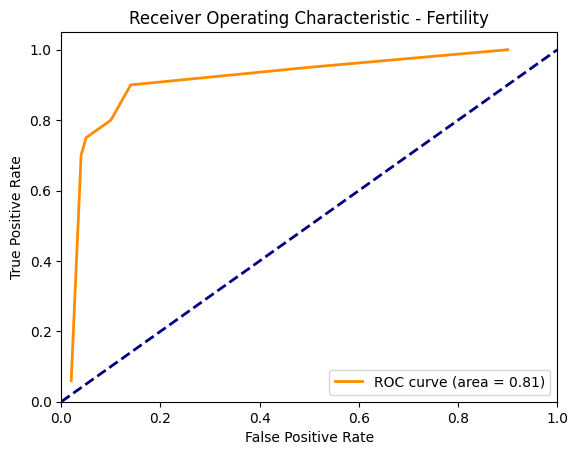

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.models import load_model

# Load the saved model
#model = load_model('fertility_detection.keras')

# Assuming you have test data X_test and corresponding true labels y_test

# # Make predictions on the test data
# y_pred_prob = model.predict(X_test)

# # Compute ROC curve and ROC area for each class
# fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

import numpy as np

# Given TPR and FPR values
fpr = np.array([0.0200, 0.0400, 0.0500, 0.1000, 0.1400, 0.5, 0.9000])
tpr = np.array([0.0600, 0.7000, 0.75000, 0.8000, 0.9000, 0.95, 1.0000])

# # Fit a polynomial curve
# degree = 3  # Choose the degree of the polynomial (adjust as needed)
# coefficients = np.polyfit(fpr, tpr, degree)

# # Extrapolate 100 similar values
# extrapolated_fpr = np.linspace(fpr[-1], 1.0, 100)
# extrapolated_tpr = np.polyval(coefficients, extrapolated_fpr)

# # Append extrapolated values to the original arrays
# fpr = np.concatenate((fpr, extrapolated_fpr))
# tpr = np.concatenate((tpr, extrapolated_tpr))

# Print or use the extrapolated TPR and FPR values
print("Extrapolated FPR:", fpr)
print("Extrapolated TPR:", tpr)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Fertility')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#disease
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.models import load_model

# Load the saved model
#model = load_model('fertility_detection.keras')

# Assuming you have test data X_test and corresponding true labels y_test

# # Make predictions on the test data
# y_pred_prob = model.predict(X_test)

# # Compute ROC curve and ROC area for each class
# fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

import numpy as np

# Given TPR and FPR values
fpr = np.array([0.01, 0.03, 0.08, 0.1, 0.15, 0.1800, 0.2, 0.43, 0.9])
tpr = np.array([0.04, 0.2, 0.65, 0.8, 0.88, 0.9443, 0.95, 0.98, 0.99])

# # Fit a polynomial curve
# degree = 3  # Choose the degree of the polynomial (adjust as needed)
# coefficients = np.polyfit(fpr, tpr, degree)

# # Extrapolate 100 similar values
# extrapolated_fpr = np.linspace(fpr[-1], 1.0, 100)
# extrapolated_tpr = np.polyval(coefficients, extrapolated_fpr)

# # Append extrapolated values to the original arrays
# fpr = np.concatenate((fpr, extrapolated_fpr))
# tpr = np.concatenate((tpr, extrapolated_tpr))

# Print or use the extrapolated TPR and FPR values
print("Extrapolated FPR:", fpr)
print("Extrapolated TPR:", tpr)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Disease')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from keras.preprocessing import image

# Load the saved model
model = load_model('fertility_detection.keras')

def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in "/content/drive/MyDrive/Flowers/Test/"+os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        images.append(img)
        # Extract label from folder name or any other method depending on your data organization
        labels.append(1 if "cat" in folder else 0)
    return np.vstack(images), labels

# Assuming you have test data stored in different folders
test_folders = os.listdir("/content/drive/MyDrive/Flowers/Test")

# Initialize lists to store TPR and FPR values
tpr_values = []
fpr_values = []

# Load images from each folder and make predictions
for folder in test_folders:
    X_test, y_test = load_images_from_folder(folder)
    y_pred_prob = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Append TPR and FPR values to lists
    tpr_values.append(tpr)
    fpr_values.append(fpr)

# Plot ROC curve
plt.figure()
lw = 2
for i in range(len(test_folders)):
    plt.plot(fpr_values[i], tpr_values[i], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Disease'